In [167]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv, ast, psycopg2
import os
import sqlite3
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import json 
from chart_studio.plotly import iplot
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

from sqlite3 import Error
from collections import Counter

def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql(query_sql):

    c = conn.cursor()
    c.execute(query_sql)
    conn.commit()
    rows = pd.DataFrame(c.fetchall())
    return rows


In [2]:
df = pd.read_csv('survey_results_public.csv')
df.head()

/home/mavericku/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


## AUTOMATE TABLE CREATION

We first input the files in to the Database

In [3]:
## Determining data type
def determine_data_type_of_list(values):  
    if type(values) == list:
        do_float = 0
        do_string = 0
        do_int = 0
        for x in values: 
            #print(x)
            try: 
                test_x_float = float(x) 
                try:
                    test_x_int = int(x) 
                except:
                    test_x_int = float(x)
                    do_float += 1 
                if int(test_x_float) == test_x_int:  
                    do_int +=1
                else:
                    do_float +=1 
            except:              
                do_string +=1
                 
        if do_string >0: 
            return str
        elif do_float > 0 : 
            return float
        else : 
            return int 
    else:
        return determine_data_type(values)

In [4]:
all_columns = [] 
main_table = "stack_overflow_survey"

In [5]:
statement = 'create table if not exists ' + main_table  + ' (' 
for column in df.columns.values:
    all_columns.append(column)
    column_data_type = determine_data_type_of_list(df[column].tolist())
#     print(column_data_type)
    if column_data_type == str: 
        statement = (statement + '\n{} text,').format(column.lower() )
    elif column == "Respondent":
        
        statement = (statement + '\n{} int not null primary key,').format(column.lower() )
    else:
        statement = (statement + '\n' + '{} {}' + ',').format(column.lower(), "int") 
statement = statement[:-1] + ');' 

In [6]:
#CREATE TABLES
create_table_sql = statement
sql_table_name = "Stack_Over_Flow_Survey.db"
conn = create_connection(sql_table_name) 
create_table(conn , create_table_sql)

In [7]:
insert_sql = """INSERT INTO stack_overflow_survey (respondent, hobby, opensource, country, student, employment, formaleducation, undergradmajor, companysize, devtype, yearscoding, yearscodingprof, jobsatisfaction, careersatisfaction, hopefiveyears, jobsearchstatus, lastnewjob, assessjob1, assessjob2, assessjob3, assessjob4, assessjob5, assessjob6, assessjob7, assessjob8, assessjob9, assessjob10, assessbenefits1, assessbenefits2, assessbenefits3, assessbenefits4, assessbenefits5, assessbenefits6, assessbenefits7, assessbenefits8, assessbenefits9, assessbenefits10, assessbenefits11, jobcontactpriorities1, jobcontactpriorities2, jobcontactpriorities3, jobcontactpriorities4, jobcontactpriorities5, jobemailpriorities1, jobemailpriorities2, jobemailpriorities3, jobemailpriorities4, jobemailpriorities5, jobemailpriorities6, jobemailpriorities7, updatecv, currency, salary, salarytype, convertedsalary, currencysymbol, communicationtools, timefullyproductive, educationtypes, selftaughttypes, timeafterbootcamp, hackathonreasons, agreedisagree1, agreedisagree2, agreedisagree3, languageworkedwith, languagedesirenextyear, databaseworkedwith, databasedesirenextyear, platformworkedwith, platformdesirenextyear, frameworkworkedwith, frameworkdesirenextyear, ide, operatingsystem, numbermonitors, methodology, versioncontrol, checkincode, adblocker, adblockerdisable, adblockerreasons, adsagreedisagree1, adsagreedisagree2, adsagreedisagree3, adsactions, adspriorities1, adspriorities2, adspriorities3, adspriorities4, adspriorities5, adspriorities6, adspriorities7, aidangerous, aiinteresting, airesponsible, aifuture, ethicschoice, ethicsreport, ethicsresponsible, ethicalimplications, stackoverflowrecommend, stackoverflowvisit, stackoverflowhasaccount, stackoverflowparticipate, stackoverflowjobs, stackoverflowdevstory, stackoverflowjobsrecommend, stackoverflowconsidermember, hypotheticaltools1, hypotheticaltools2, hypotheticaltools3, hypotheticaltools4, hypotheticaltools5, waketime, hourscomputer, hoursoutside, skipmeals, ergonomicdevices, exercise, gender, sexualorientation, educationparents, raceethnicity, age, dependents, militaryus, surveytoolong, surveyeasy) 
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""
# # print(statement)
# print(len(all_columns))

# for i in range(0 , 129):
#     print("?, ", end = "")

In [8]:
# print(insert_sql)

In [9]:
# INSERT FUNCTION
def insert_rows_to_db(conn, data_tuple): 
    try:
        c = conn.cursor()
        c.executemany(insert_sql, data_tuple)
        conn.commit()
    except Error as e:  
        print(e)

In [10]:
# EXTRACT DATA
index_print_times = 0
test_times = 30
all_respondet_answer_tuple = []
for index, value in  df.iterrows(): 
    respondent_answer_tuple = [] 
    for columns in all_columns: 
        respondent_answer_tuple.append(value[columns])
        index_print_times += 1  
#     insert_rows_to_db(conn, tuple(respondent_answer_tuple))
    all_respondet_answer_tuple.append(tuple(respondent_answer_tuple)) 
    
############### IF ERROR, DELETE .DB FILE THEN RERUN #########################

In [11]:
# INSERT TO DB
insert_rows_to_db(conn, all_respondet_answer_tuple)

UNIQUE constraint failed: stack_overflow_survey.respondent


# First, we analyze our users

We first take a look at the respondents that have taken the survey
We wish to know
1. The amount of respondents from each of the countries
2. The male/female ratio
3. The age group of respondents
4. How many code as a hobby
5. The typical degree type and major
6. Type of developer

In [12]:
select_sql = "SELECT ? "
select_from_table = "FROM " + main_table
select_columns = ["Respondent", "Hobby" , "OpenSource" , "Country" , "Student" , "Employment" , 
                  "FormalEducation" , "UndergradMajor" , "CompanySize" , "DevType" , "YearsCoding" ,
                  "YearsCodingProf" , "JobSatisfaction" , "CareerSatisfaction" , "HopeFiveYears" , "JobSearchStatus" , 
                  "LastNewJob" ,"Age" , "MilitaryUS" , "RaceEthnicity" , "EducationParents" , "Gender" ,"WakeTime" ,
                  "HoursComputer" , "HoursOutside" , "SkipMeals" , "ErgonomicDevices"]

In [13]:
select_column_whole = " "
for column in select_columns:
    select_column_whole = select_column_whole + column + " ,"
select_column_whole = select_column_whole[:-1] 
select_sql = select_sql.replace("?" , select_column_whole, 1) + select_from_table 

In [14]:
c = conn.cursor()
c.execute(select_sql)
conn.commit()

In [15]:
select_respondent_reponse = c.fetchall()
selected_response = pd.DataFrame(select_respondent_reponse , columns = select_columns)
selected_response = selected_response.set_index('Respondent')

In [16]:
selected_response.head()

,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,...,Age,MilitaryUS,RaceEthnicity,EducationParents,Gender,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices
Respondent,,,,,,,,,,,,,,,,,,,,,
1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,...,25 - 34 years old,None,Black or of African descent,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Male,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,Standing desk
3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,...,35 - 44 years old,None,White or of European descent,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Male,Between 6:01 - 7:00 AM,5 - 8 hours,30 - 59 minutes,Never,Ergonomic keyboard or mouse
4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,24-26 years,...,None,None,None,None,None,None,None,None,None,None
5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,18-20 years,...,35 - 44 years old,No,White or of European descent,Some college/university study without earning ...,Male,Between 6:01 - 7:00 AM,9 - 12 hours,Less than 30 minutes,3 - 4 times per week,None
7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,6-8 years,...,18 - 24 years old,None,White or of European descent,Some college/university study without earning ...,Male,Before 5:00 AM,Over 12 hours,1 - 2 hours,Never,None


## Developers from around the country

In [17]:
# DEVELOPERS FROM AROUND THE COUNTRY
country_responses = set(selected_response["Country"])
total_appearance_of_each_country = Counter(selected_response["Country"])

# print(len(country_responses))
# print(total_appearance_of_each_country)
# Counter({'United States': 20309, 'India': 13721, 'Germany': 6459, 'United Kingdom': 6221, 'Canada': 3393, 'Russian Federation': 2869, 'France': 2572, 'Brazil': 2505, 'Poland': 2122, 'Australia': 2018, 'Netherlands': 1841, 'Spain': 1769, 'Italy': 1535, 'Ukraine': 1279, 'Sweden': 1164, 'Pakistan': 1050, 'China': 1037, 'Switzerland': 1010, 'Turkey': 1004, 'Israel': 1003, 'Iran, Islamic Republic of...': 921, 'Romania': 793, 'Austria': 788, 'Czech Republic': 784, 'Belgium': 743, 'Mexico': 736, 'Bangladesh': 697, 'Denmark': 653, 'South Africa': 637, 'Indonesia': 630, 'Argentina': 611, 'Norway': 565, 'New Zealand': 557, 'Ireland': 554, 'Portugal': 528, 'Finland': 521, 'Philippines': 520, 'Greece': 516, 'Hungary': 470, 'Sri Lanka': 454, 'Bulgaria': 425, 'Egypt': 419, None: 412, 'Nigeria': 399, 'Singapore': 376, 'Malaysia': 363, 'Japan': 361, 'Serbia': 358, 'Colombia': 339, 'Belarus': 339, 'Viet Nam': 331, 'Nepal': 295, 'Lithuania': 257, 'Croatia': 241, 'Chile': 238, 'Slovakia': 238, 'Slovenia': 238, 'Hong Kong (S.A.R.)': 219, 'Thailand': 213, 'Morocco': 213, 'Taiwan': 207, 'Kenya': 194, 'United Arab Emirates': 193, 'Estonia': 189, 'South Korea': 169, 'Tunisia': 163, 'Latvia': 145, 'Algeria': 130, 'Saudi Arabia': 130, 'Peru': 128, 'Bosnia and Herzegovina': 125, 'Venezuela, Bolivarian Republic of...': 123, 'Armenia': 117, 'Dominican Republic': 115, 'Albania': 109, 'Lebanon': 107, 'Kazakhstan': 107, 'Uruguay': 102, 'Costa Rica': 98, 'Other Country (Not Listed Above)': 84, 'Jordan': 83, 'Azerbaijan': 78, 'Ghana': 76, 'Republic of Moldova': 76, 'Georgia': 75, 'Uganda': 67, 'Malta': 66, 'Cuba': 65, 'Ecuador': 65, 'Afghanistan': 64, 'Republic of Korea': 62, 'Cambodia': 60, 'Ethiopia': 60, 'Luxembourg': 59, 'Uzbekistan': 56, 'Syrian Arab Republic': 56, 'Myanmar': 55, 'The former Yugoslav Republic of Macedonia': 54, 'Guatemala': 50, 'Paraguay': 49, 'United Republic of Tanzania': 49, 'Cyprus': 49, 'El Salvador': 46, 'Iceland': 45, 'Bolivia': 44, 'Iraq': 42, 'Zimbabwe': 39, 'Mauritius': 35, 'Cameroon': 34, 'Panama': 32, 'Nicaragua': 31, 'Honduras': 25, 'Sudan': 25, 'Qatar': 23, 'Kuwait': 23, 'Kyrgyzstan': 22, 'Mozambique': 21, 'Mongolia': 21, 'Oman': 20, 'Jamaica': 20, 'Trinidad and Tobago': 20, 'Madagascar': 19, 'Rwanda': 18, 'Bahrain': 16, 'Montenegro': 15, 'Andorra': 15, 'Libyan Arab Jamahiriya': 14, 'Yemen': 13, 'Senegal': 13, 'Angola': 11, 'Somalia': 10, 'Maldives': 10, 'Benin': 10, 'Antigua and Barbuda': 9, 'Malawi': 9, 'Zambia': 9, 'Fiji': 8, 'Haiti': 8, 'Democratic Republic of the Congo': 7, "Côte d'Ivoire": 7, 'Bhutan': 6, 'Turkmenistan': 6, 'Namibia': 6, 'Bahamas': 6, 'Congo, Republic of the...': 6, 'Liechtenstein': 5, 'Gabon': 5, 'Gambia': 5, 'Togo': 5, 'Burkina Faso': 5, 'Botswana': 4, 'Barbados': 4, 'Tajikistan': 4, 'Monaco': 4, 'North Korea': 4, 'Swaziland': 3, 'Guinea': 3, 'Mauritania': 3, 'Liberia': 3, 'Cape Verde': 3, 'Micronesia, Federated States of...': 2, 'Lesotho': 2, 'Marshall Islands': 2, 'Central African Republic': 2, 'Palau': 2, 'Suriname': 2, 'Dominica': 2, 'Niger': 2, 'Guyana': 2, "Democratic People's Republic of Korea": 2, 'San Marino': 1, 'Burundi': 1, 'Sierra Leone': 1, 'Grenada': 1, 'Belize': 1, 'Timor-Leste': 1, 'Solomon Islands': 1, 'Saint Lucia': 1, 'Nauru': 1, 'Mali': 1, 'Brunei Darussalam': 1, 'Eritrea': 1, 'Djibouti': 1, 'Guinea-Bissau': 1})

In [123]:

# # Calculate the Mean
# total_num = 0
# for items in total_appearance_of_each_country.items():
#     total_num += items[1]
# print(total_num / (len(total_appearance_of_each_country.items())))
 

In [119]:
selected_10_countries = selected_response["Country"].dropna().value_counts().head(20)   
print(selected_10_countries)

United States         20309
India                 13721
Germany                6459
United Kingdom         6221
Canada                 3393
Russian Federation     2869
France                 2572
Brazil                 2505
Poland                 2122
Australia              2018
Netherlands            1841
Spain                  1769
Italy                  1535
Ukraine                1279
Sweden                 1164
Pakistan               1050
China                  1037
Switzerland            1010
Turkey                 1004
Israel                 1003
Name: Country, dtype: int64


In [120]:
country_label = []
country_count = []
for i in selected_10_countries:
    country_label.append(selected_10_countries[selected_10_countries == i ].index[0])
    country_count.append(i)

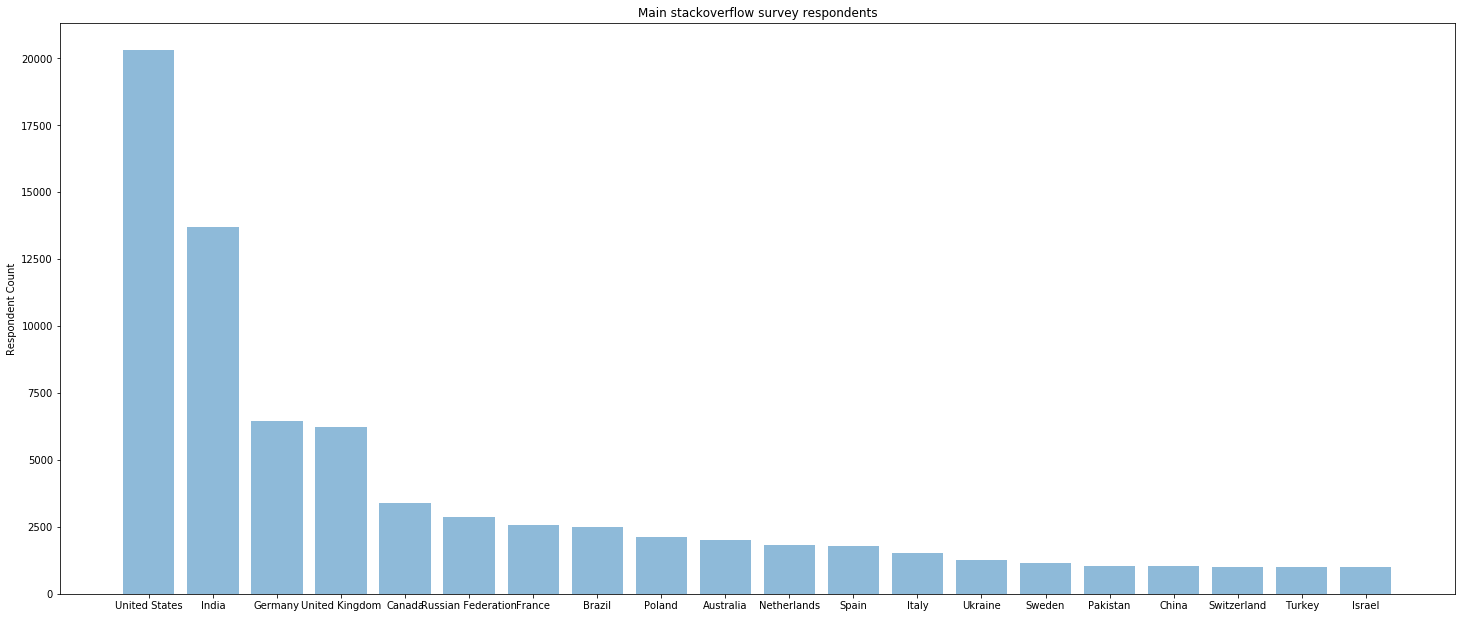

In [121]:
plt.bar(country_label, country_count, align='center', alpha=0.5)
plt.xticks(country_label)
plt.ylabel('Respondent Count')
plt.title('Main stackoverflow survey respondents')

plt.savefig("./Figure/CountryRespondents.png")
fig = plt.gcf()
fig.set_size_inches(25, 10.5)
plt.show()

In [124]:
country_label

['United States',
 'India',
 'Germany',
 'United Kingdom',
 'Canada',
 'Russian Federation',
 'France',
 'Brazil',
 'Poland',
 'Australia',
 'Netherlands',
 'Spain',
 'Italy',
 'Ukraine',
 'Sweden',
 'Pakistan',
 'China',
 'Switzerland',
 'Turkey',
 'Israel']

### Out of the 98,855 respondents, there were developers from 184 countries involved!
Out of the 184 countries the top contributing countries are
['United States',
 'India',
 'Germany',
 'United Kingdom',
 'Canada',
 'Russian Federation',
 'France',
 'Brazil',
 'Poland',
 'Australia',
 'Netherlands',
 'Spain',
 'Italy',
 'Ukraine',
 'Sweden',
 'Pakistan',
 'China',
 'Switzerland',
 'Turkey',
 'Israel']

---
## Now we check out the gender ratio

In [125]:
gender_responses = selected_response["Gender"]
# print(gender_responses)
total_gender_responses = []
for i in gender_responses: 
    if i != None:
        i = i.split(";") 
        if type(i) == list:
            for q in i :
                total_gender_responses.append(q)
        else:
            total_gender_responses.append(i)
        
        
set_gender_response = set(total_gender_responses)
print(set_gender_response)
# print(json.dumps(gender_set_responses , indent = 4))
# total_appearance_of_each_country = Counter(selected_response["Country"])

{'Male', 'Non-binary, genderqueer, or gender non-conforming', 'Female', 'Transgender'}


In [51]:
gender_dict = {}
gender_dict["Male"] = 0
gender_dict["Female"] = 0 
gender_dict["Others"] = 0
gender_dict["Undisclosed"] = 0
for i in selected_response["Gender"]:
#     print(i) 
    if i is None: 
        gender_dict["Undisclosed"] +=1 
    elif "Male" in i:
        gender_dict["Male"] += 1
    elif "Female" in i :
        gender_dict["Female"] +=1 
    else:
        gender_dict["Others"] +=1 
    

In [54]:
gender_count = []
gender_count.append(gender_dict["Male"])
gender_count.append(gender_dict["Female"])
gender_count.append(gender_dict["Undisclosed"])
gender_count.append(gender_dict["Others"])
gender_label = "Male" , "Female" , "Undisclosed" , "Others"

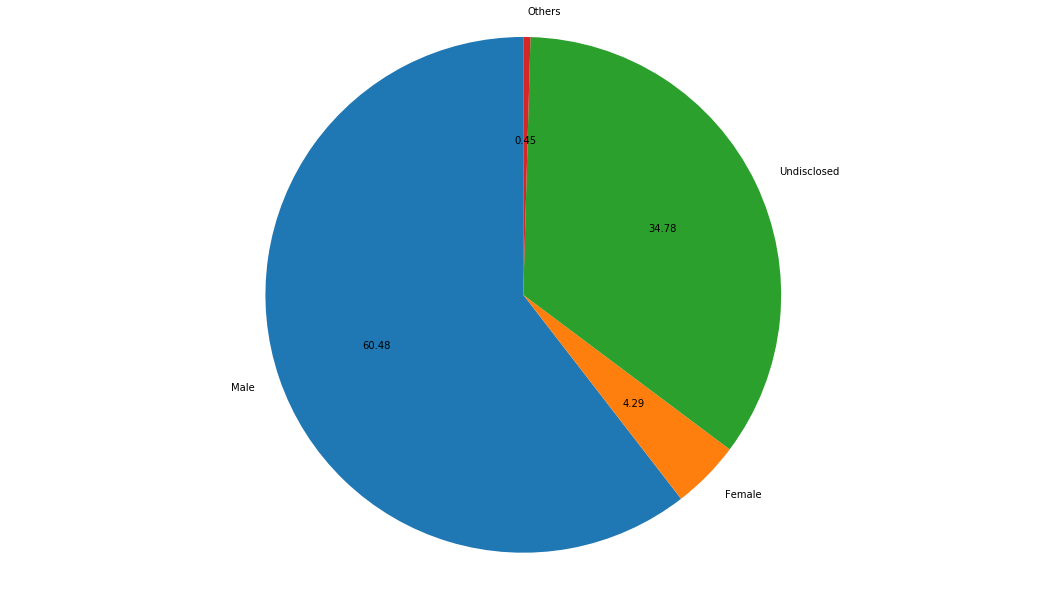

In [164]:
# GRAPHING GENDER
figureObject, axesObject = plt.subplots() 

plt.pie(gender_count,
        labels=gender_label, 
        autopct='%1.2f', 
        startangle=90) 

plt.axis('equal')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.savefig("./Figure/GenderPlot.png")

plt.show()

---
## Now we visualize the age groups

In [180]:
age_responses = selected_response["Age"]

In [181]:
age_responses.unique()

array(['25 - 34 years old', '35 - 44 years old', None,
       '18 - 24 years old', '45 - 54 years old', '55 - 64 years old',
       'Under 18 years old', '65 years or older'], dtype=object)

In [182]:
age_responses = selected_response.groupby("Age").nunique()

In [183]:
age_responses = selected_response.Age.value_counts()

In [157]:
age_label = []
age_value = []
for i in age_responses:
#     print*()
    age_label.append(age_responses[age_responses == i].index[0])
    age_value.append(i)

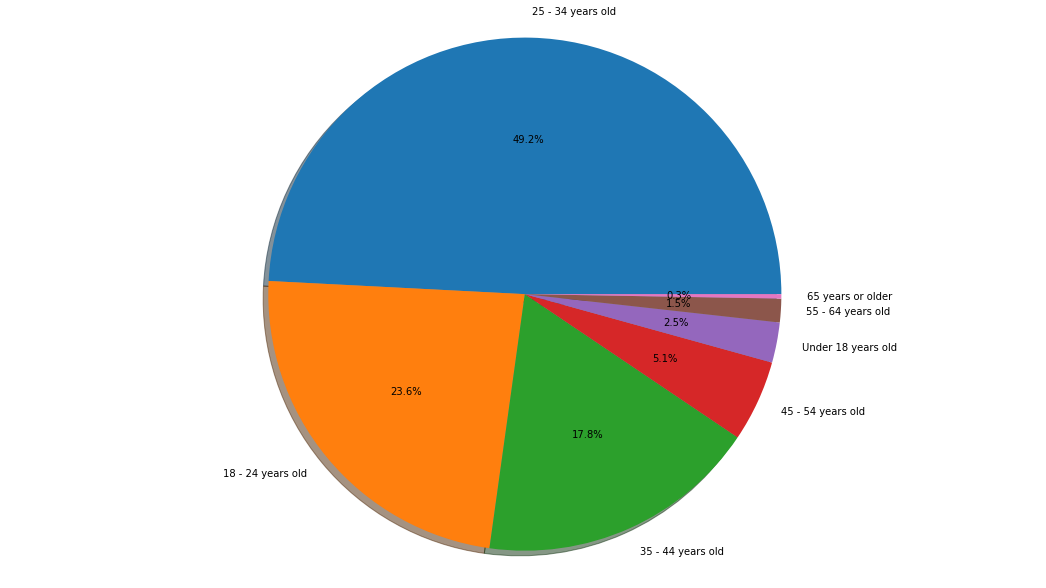

In [166]:
fig1, ax1 = plt.subplots()
ax1.pie(age_value, labels=age_label, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("./Figure/age_pie")
plt.show()

---
## Visualize contribution to open source

In [207]:
open_source_response = selected_response["OpenSource"]

In [208]:
open_source_count_unique = selected_response.OpenSource.value_counts()

In [209]:
open_source_label = []
open_source_count_total = []
for i in open_source_count_unique: 
    open_source_label.append(open_source_count[open_source_count == i ].index[0])
    open_source_count_total.append(i)

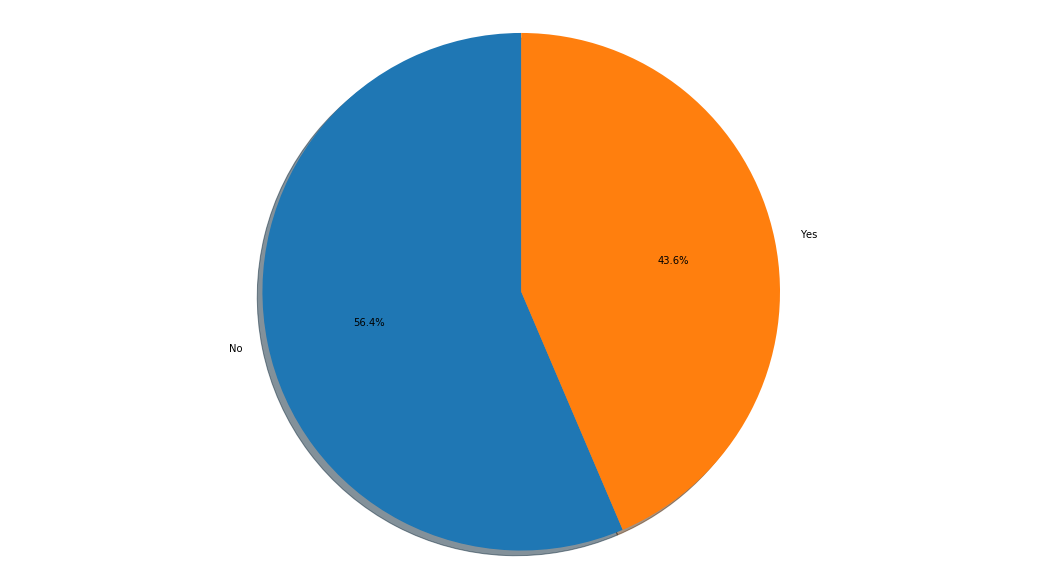

In [212]:
fig1, ax1 = plt.subplots()
ax1.pie(open_source_count_total, labels=open_source_label, autopct='%1.1f%%', shadow=True,
        startangle=90)
ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("./Figure/open_source")
plt.show()

---
## Now we try to look at the types of job we get for each age group

In [215]:
jobs_to_year_dev = selected_response[["DevType" , "YearsCoding"]]

In [218]:
jobs_to_year_dev.YearsCoding.unique()

array(['3-5 years', '30 or more years', '24-26 years', '18-20 years',
       '6-8 years', '9-11 years', '0-2 years', '15-17 years',
       '12-14 years', '21-23 years', '27-29 years', None], dtype=object)

In [225]:
jobs_to_years_series = jobs_to_year_dev.YearsCoding.value_counts()

In [243]:
jobs_to_years_dict = {} 
for i in jobs_to_years_series: 
    jobs_to_years_dict[str(jobs_to_years_series[jobs_to_years_series == i ].index[0])] = i 
jobs_to_years_dict_keys = jobs_to_years_dict.keys()
jobs_to_years_dict_value = jobs_to_years_dict.values()